In [1]:
! pip install gym

Project Description:

Deterministic environmet:
Actions: 4 - left, right, top, bottom
States: 16 states (4*4 grid)
Rewards: 
Three positive rewards- Drinking Coffee-0.3, Studying-0.6, End Goal-1
Two Negative rewards- Bunk class- -0.5

Deterministic environmet:
Actions: 5 - left, right, top, bottom, stay in same position
States: 16 states (4*4 grid)
Rewards: 
Three positive rewards- Drinking Coffee-0.3, Studying-0.6, End Goal-1
Two Negative rewards- Bunk class- -0.5


In [534]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep
from scipy.stats import binom
from operator import add
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import random
import pandas as pd
from IPython.display import clear_output


In [541]:
class GridEnvironment(gym.Env):
    
    def __init__(self):
        print("Intitializing the Env....")
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.positive_reward_1=[2,2]
        self.positive_reward_2=[1,1]
        self.negative_reward_1=[2,0]
        self.negative_reward_2=[0,2]
        
        self.state = np.zeros((4, 4))
        observation = self.state.flatten()
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100     
        self.qtable=np.zeros((self.observation_space.n,self.action_space.n))
        
        values=[i for i in range(16)]
        keys=[]
        for i in range(4):
            for j in range(4):
                keys.append((i,j))
        self.mapping=dict(zip(keys,values))
        
        self.num_of_episodes=200
        self.reward_per_episode_array=[]
        self.qtables_array=[]
        self.rewards_in_episode_for_optimal_policy=[]
        self.winning_state=[]
        self.episilon_decay_array=[]
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.positive_reward_1=[2,2]
        self.positive_reward_2=[1,1]
        self.negative_reward_1=[2,0]
        self.negative_reward_2=[0,2]
        self.state = np.zeros((4, 4)) 
#         self.qtable=np.zeros((self.observation_space.n,self.action_space.n))
        observation = self.state.flatten()
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100
        values=[i for i in range(16)]
        keys=[]
        for i in range(4):
            for j in range(4):
                keys.append((i,j))
        self.mapping=dict(zip(keys,values))
        
        return observation
    
    def step(self,env_type,action):
        if(env_type=='D'):
            if action == 0:
                self.agent_pos[0] += 1
            if action == 1:
                self.agent_pos[0] -= 1
            if action == 2:
                self.agent_pos[1] += 1
            if action == 3:
                self.agent_pos[1] -= 1
        else:
            #random value here is either or 1
            random_value=self.get_random_value_by_probability()
            if action == 0:
                self.agent_pos[0] += random_value
            if action == 1:
                self.agent_pos[0] -= random_value
            if action == 2:
                self.agent_pos[1] += random_value
            if action == 3:
                self.agent_pos[1] -= random_value
                
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        
        info = {}        
        observation = self.state.flatten()
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
            reward = 10
            done=True
            new_agent_pos=self.mapping[tuple(self.agent_pos)]
            return new_agent_pos, reward, done, info
        elif (self.agent_pos == self.positive_reward_1).all():
            reward=6
        elif (self.agent_pos == self.positive_reward_2).all():
            reward=3
        elif(self.agent_pos == self.negative_reward_1).all():
            reward= -5
        elif(self.agent_pos == self.negative_reward_2).all():
            reward= -6
            
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps else False
        
        new_agent_pos=self.mapping[tuple(self.agent_pos)]
        return new_agent_pos, reward, done, info
    
    def get_random_value_by_probability(self):
        x=np.random.randint(0, 10)
        random_value=0
        if x <= 6:
            random_value=1
        print("RANDOM VAL",random_value)
        return random_value
    
    def render(self):
        plt.imshow(self.state)
        
    def render2(self,mode='human',plot=False):
        fig,ax=plt.subplots(2,2,figsize=(10,10))
        ax.set_xlim(0,4)
        ax.set_ylim(0,4)
                
        agent = AnnotationBbox(OffsetImage(plt.imread('./images/robot/Robot_pos1.png'), zoom=0.4),  # Plotting the agent.
                           list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
        ax.add_artist(agent)

        if (self.agent_pos == self.goal_pos).all():
            goal = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/grad.png'), zoom=0.12),  # Plotting the agent.
                           list(map(add, self.goal_pos, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            goal = AnnotationBbox(OffsetImage(plt.imread('./images/RL-696x309.png'), zoom=0.2),  # Plotting the agent.
                           list(map(add, self.goal_pos, [0.5, 0.5])), frameon=False)
        ax.add_artist(goal)
        
        if(self.agent_pos == self.negative_reward_1).all():
            negative_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/Conf_bunk.png'), zoom=0.11),  # Plotting the agent.
                           list(map(add, self.negative_reward_1, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            negative_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/bunk.jpeg'), zoom=0.4),  # Plotting the agent.
                           list(map(add, self.negative_reward_1, [0.5, 0.5])), frameon=False)
        ax.add_artist(negative_rw_1)
        
        if(self.agent_pos == self.negative_reward_2).all():
            negative_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/Conf_bunk.png'), zoom=0.11),  # Plotting the agent.
                           list(map(add, self.negative_reward_2, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            negative_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/bunk.jpeg'), zoom=0.4),  # Plotting the agent.
                           list(map(add, self.negative_reward_2, [0.5, 0.5])), frameon=False)
        ax.add_artist(negative_rw_2)
        
        if(self.agent_pos == self.positive_reward_1).all():
            positive_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/assignment.png'), zoom=0.21),  # Plotting the agent.
                           list(map(add, self.positive_reward_1, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            positive_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/books.png'), zoom=0.15),  # Plotting the agent.
                           list(map(add, self.positive_reward_1, [0.5, 0.5])), frameon=False)
        ax.add_artist(positive_rw_1)
        
        if(self.agent_pos == self.positive_reward_2).all():
            positive_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/robot_coffee_final.png'), zoom=0.25),  # Plotting the agent.
                           list(map(add, self.positive_reward_2, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            positive_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/coffee.png'), zoom=0.15),  # Plotting the agent.
                           list(map(add, self.positive_reward_2, [0.5, 0.5])), frameon=False)
        ax.add_artist(positive_rw_2)
        
        ax.set_xticks(np.arange(0, 4, 1))
        ax.set_yticks(np.arange(0, 4, 1))
        plt.grid(fig, linewidth=1,which='both', axis='both')

    

In [542]:
def navigate(function_type,env_type):
    env = GridEnvironment()
    if(function_type=='QL'):
        qtable_Q_learning=getQTableQL(env_type,env)
    elif(function_type=='SARSA'):
        qtable_Q_learning=getQTableSARSA(env_type,env)

def getQTableQL(env_type,env):
    print("<-------------------Q-Learning-------------------->")
    if(env_type=='D'):
        print("<-------------------Deterministic Environment-------------------->")
    elif(env_type=='S'):
        print("<-------------------Stochastic Environment-------------------->")
    for episode in range(env.num_of_episodes):
        #learning rate
        alpha=0.4
        #discount rate
        gamma=0.7
    
        exploration_rate = 1
        max_exploration_rate = 1
        min_exploration_rate = 0.01
        exploration_decay_rate = 0.01
        
        env.reset()
        cum_reward_per_episode=0
        actions_in_one_episode=[]
        states_passed_in_one_episode=[]
        rewards_in_episode=[]
        states_passed_in_one_episode.append(env.mapping[tuple(env.agent_pos)])
        greedy_a=0
        random_a=1
        while True:
            state=env.mapping[tuple(env.agent_pos)]
            qtable_state=env.qtable[state]
            greedy_action=np.argmax(qtable_state)
            greedy_q_value= max(qtable_state)
        
            expl_rate_threshold=random.uniform(0,1)
            if expl_rate_threshold> exploration_rate:
                action=greedy_action
                greedy_a=greedy_a+1
            else:
                action=env.action_space.sample()
                random_a=random_a+1
            env.episilon_decay_array.append(exploration_rate)

            new_observation, reward, done, _ = env.step('D',action)
                        
            if(new_observation in states_passed_in_one_episode):
                reward= -1            
            if(new_observation==state):
                reward= -10
            
            qtable_state[action]=qtable_state[action]+(alpha*(reward+gamma*max(env.qtable[new_observation])-qtable_state[[action]]))
            
            env.qtable[state]=qtable_state
            
            actions_in_one_episode.append(action)
            states_passed_in_one_episode.append(new_observation)
            cum_reward_per_episode=cum_reward_per_episode+reward
            rewards_in_episode.append(reward)

            exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
            
            if done==True:
                print("One episode complete")
                print("Reward for this episode is: ",cum_reward_per_episode)
                print("Actions taken during this episode: ",actions_in_one_episode)
                print("States traversed during this episode: ",states_passed_in_one_episode)
                print("Greedy actions taken",greedy_a,"Random actions taken",random_a)
                env.reward_per_episode_array.append(cum_reward_per_episode)
                env.qtables_array.append(env.qtable)
                if(cum_reward_per_episode >= max(env.reward_per_episode_array)):
                    env.winning_state=states_passed_in_one_episode
                    env.rewards_in_episode_for_optimal_policy=rewards_in_episode
                break
    print("-----------------------------------------------------------------")
    print("Maximum reward in all episodes: ",max(env.reward_per_episode_array))
    print("Winning State Actions: ",env.winning_state)
    print("Final Q Table",env.qtable)
    plt.plot(env.reward_per_episode_array)
    plt.figure() 
    plt.plot(env.episilon_decay_array)
    display(env.winning_state,env.rewards_in_episode_for_optimal_policy)
    return env.qtable


def getQTableSARSA(env_type,env):
    print("<-------------------SARSA-------------------->")
    if(env_type=='D'):
        print("<-------------------Deterministic Environment-------------------->")
    elif(env_type=='S'):
        print("<-------------------Stochastic Environment-------------------->")
        
    for episode in range(env.num_of_episodes):
        #learning rate
        alpha=0.4
        #discount rate
        gamma=0.7
    
        exploration_rate = 1
        max_exploration_rate = 1
        min_exploration_rate = 0.01
        exploration_decay_rate = 0.01
        
        env.reset()
        cum_reward_per_episode=0
        actions_in_one_episode=[]
        states_passed_in_one_episode=[]
        rewards_in_episode=[]
        states_passed_in_one_episode.append(env.mapping[tuple(env.agent_pos)])
        greedy_a=0
        random_a=1
        while True:
            state=env.mapping[tuple(env.agent_pos)]
            qtable_state=env.qtable[state]
            greedy_action=np.argmax(qtable_state)
            greedy_q_value= max(qtable_state)
        
            expl_rate_threshold=random.uniform(0,1)
            if expl_rate_threshold> exploration_rate:
                action=greedy_action
                greedy_a=greedy_a+1
            else:
                action=env.action_space.sample()
                random_a=random_a+1
                
            env.episilon_decay_array.append(exploration_rate)
            
            new_observation, reward, done, _ = env.step('D',action)
                        
            if(new_observation in states_passed_in_one_episode):
                reward= -1            
            if(new_observation==state):
                reward= -10
           
            exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
           
            expl_rate_threshold=random.uniform(0,1)
            if expl_rate_threshold> exploration_rate:
                new_action=greedy_action
            else:
                new_action=env.action_space.sample()
                
            qtable_state[action]=qtable_state[action]+(alpha*(reward+gamma*(env.qtable[new_observation][new_action])-qtable_state[[action]]))
            
            env.qtable[state]=qtable_state
            
            actions_in_one_episode.append(action)
            states_passed_in_one_episode.append(new_observation)
            cum_reward_per_episode=cum_reward_per_episode+reward
            rewards_in_episode.append(reward)
                        
            if done==True:
                print("One episode complete")
                print("Reward for this episode is: ",cum_reward_per_episode)
                print("Actions taken during this episode: ",actions_in_one_episode)
                print("States traversed during this episode: ",states_passed_in_one_episode)
                print("Greedy actions taken",greedy_a,"Random actions taken",random_a)
                env.reward_per_episode_array.append(cum_reward_per_episode)
                env.qtables_array.append(env.qtable)
                if(cum_reward_per_episode >= max(env.reward_per_episode_array)):
                    env.winning_state=states_passed_in_one_episode
                    env.rewards_in_episode_for_optimal_policy=rewards_in_episode
                break
    print("-----------------------------------------------------------------")
    print("Maximum reward in all episodes: ",max(env.reward_per_episode_array))
    print("Winning State Traversal: ",env.winning_state)
    print("FINAL Q TABLE: ",env.qtable)
    plt.plot(env.reward_per_episode_array)
    plt.figure() 
    plt.plot(env.episilon_decay_array)
#     display(env.winning_state,env.rewards_in_episode_for_optimal_policy)
    display2(env.qtable)
    return env.qtable

def display(winning_states,winning_state_rewards):
    print("Winning state rewards",winning_state_rewards)
    inv_map = {v: k for k, v in env.mapping.items()}
    for i in range(len(winning_states)):
        print(list(inv_map.get(winning_states[i])))
        env.agent_pos=list(inv_map.get(winning_states[i]))
        env.render2()
        sleep(.1)

def display2(qtable):
    env.reset()
    print("Using Q table to move though the optimal states......")
    state=env.mapping[(0,0)]
    inv_map = {v: k for k, v in env.mapping.items()}
    while True:
        qtable_state=env.qtable[state]
        optimal_action=np.argmax(qtable_state)
        new_observation, reward, done, _ = env.step('D',optimal_action)
        state=new_observation
        print(list(inv_map.get(state)))
        env.agent_pos=list(inv_map.get(state))
        env.render2()
        sleep(.1)
        if(done):
            break



Intitializing the Env....
<-------------------Q-Learning-------------------->
<-------------------Deterministic Environment-------------------->
One episode complete
Reward for this episode is:  -111
Actions taken during this episode:  [1, 2, 1, 2, 1, 0, 1, 1, 2, 3, 3, 3, 1, 3, 3, 0, 3, 1, 2, 0, 2, 0, 1, 1, 0, 1, 3, 0, 2, 2, 2, 2, 0, 2, 0]
States traversed during this episode:  [0, 0, 1, 1, 2, 2, 6, 2, 2, 3, 2, 1, 0, 0, 0, 0, 4, 4, 0, 1, 5, 6, 10, 6, 2, 6, 2, 1, 5, 6, 7, 7, 7, 11, 11, 15]
Greedy actions taken 0 Random actions taken 36
One episode complete
Reward for this episode is:  -57
Actions taken during this episode:  [2, 2, 0, 2, 2, 1, 0, 2, 1, 3, 0, 1, 2, 2, 2, 3, 2, 0, 0, 1, 2, 0, 0]
States traversed during this episode:  [0, 1, 2, 6, 7, 7, 3, 7, 7, 3, 2, 6, 2, 3, 3, 3, 2, 3, 7, 11, 7, 7, 11, 15]
Greedy actions taken 0 Random actions taken 24
One episode complete
Reward for this episode is:  -44
Actions taken during this episode:  [2, 2, 3, 3, 0, 2, 3, 0, 0, 3, 3, 1, 3, 2, 0, 2

One episode complete
Reward for this episode is:  -1
Actions taken during this episode:  [1, 0, 2, 0, 2, 3, 3, 1, 0, 2, 2, 0, 2]
States traversed during this episode:  [0, 0, 4, 5, 9, 10, 9, 8, 4, 8, 9, 10, 14, 15]
Greedy actions taken 7 Random actions taken 7
One episode complete
Reward for this episode is:  3
Actions taken during this episode:  [3, 0, 2, 0, 3, 2, 2, 2, 0]
States traversed during this episode:  [0, 0, 4, 5, 9, 8, 9, 10, 11, 15]
Greedy actions taken 5 Random actions taken 5
One episode complete
Reward for this episode is:  17
Actions taken during this episode:  [0, 1, 0, 2, 0, 2, 2, 0]
States traversed during this episode:  [0, 4, 0, 4, 5, 9, 10, 11, 15]
Greedy actions taken 6 Random actions taken 3
One episode complete
Reward for this episode is:  -1
Actions taken during this episode:  [1, 0, 2, 0, 2, 0, 0, 2]
States traversed during this episode:  [0, 0, 4, 5, 9, 10, 14, 14, 15]
Greedy actions taken 4 Random actions taken 5
One episode complete
Reward for this episod

[0, 1]
[1, 1]
[1, 2]
[2, 2]
[2, 3]
[3, 3]


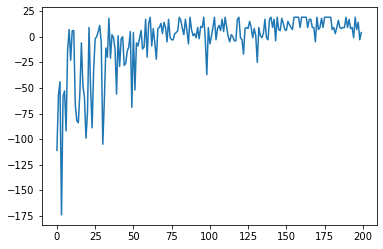

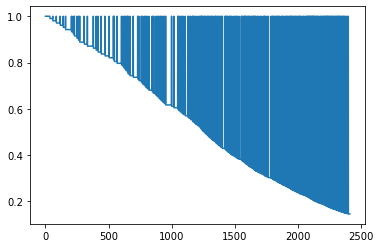

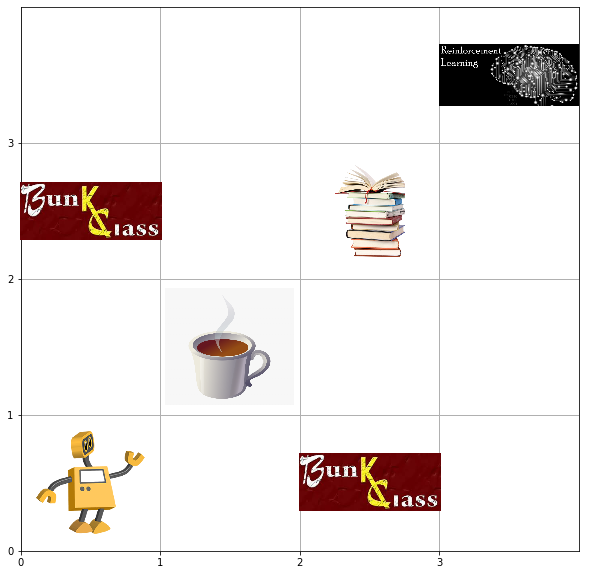

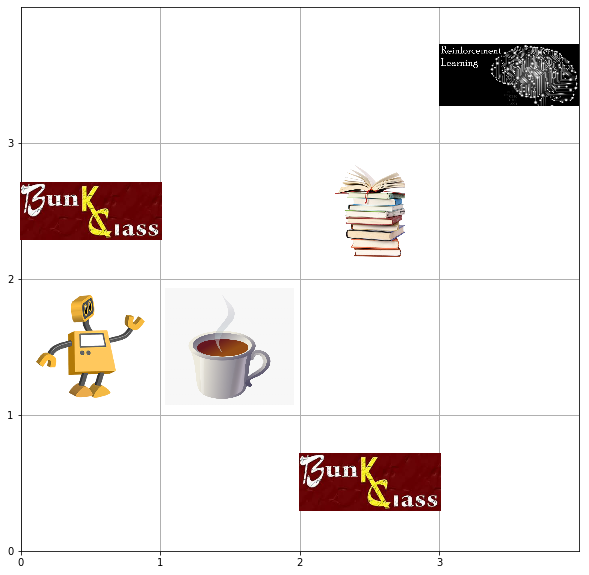

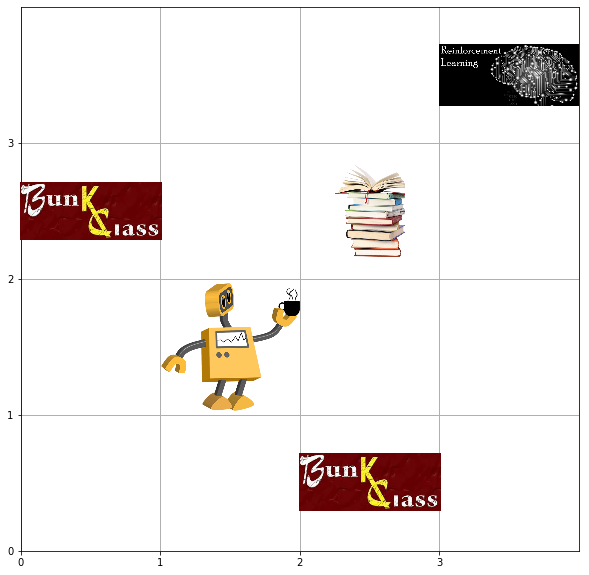

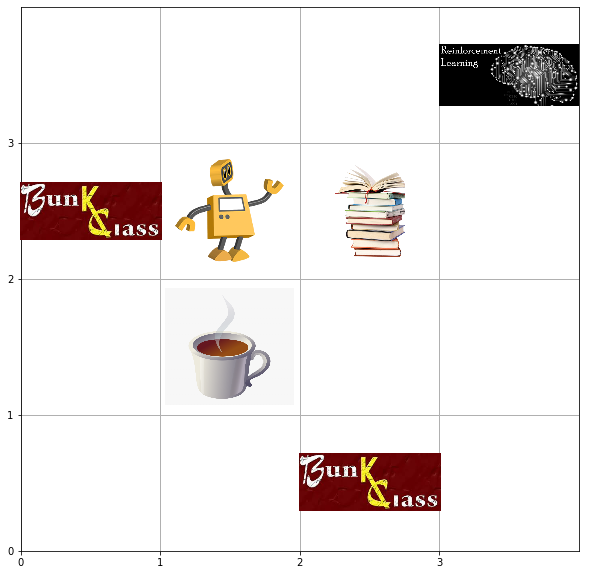

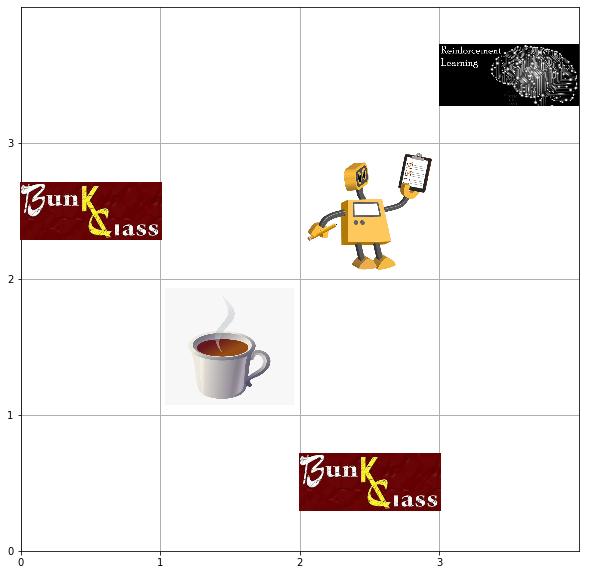

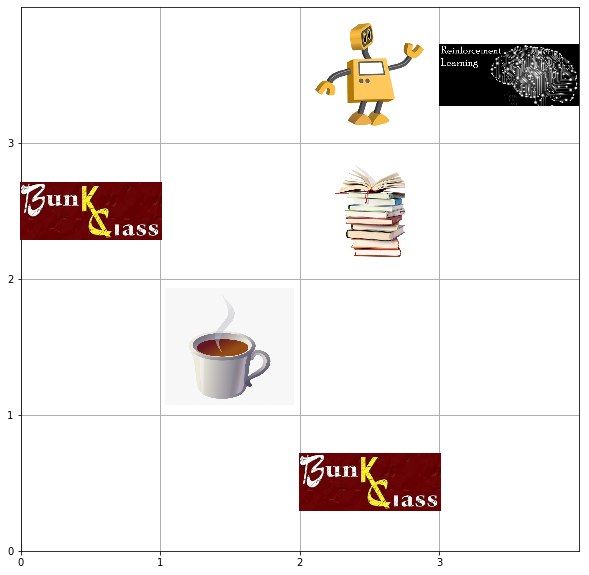

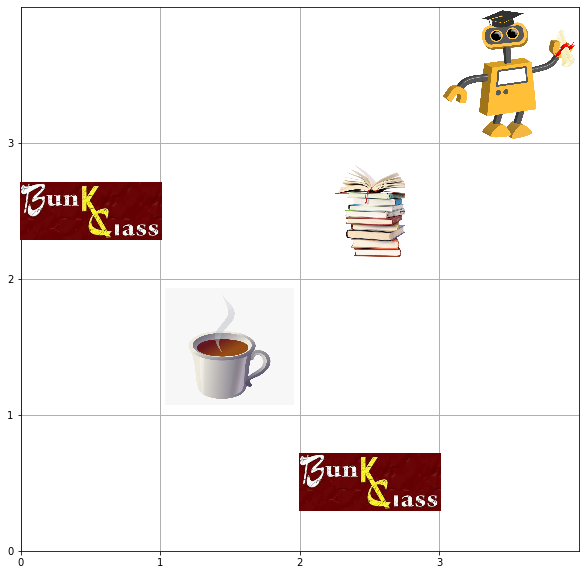

In [544]:
navigate('QL','D')